In [1]:
import sys


# script_path = "/Users/anyaphillips/Desktop/harvard/research/papers/p26/scripts" # my machine
# sys.path.append("/Users/anyaphillips/Downloads/software/petar_install/include") # for my machine
script_path = "/n/home02/amphillips/p26/scripts/"
sys.path.append(script_path)

import petar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from astropy.table import Table
from scipy.stats import binned_statistic_2d


import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms

from gala.units import galactic

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D


from tqdm import tqdm


# from analyze_petar import analyze_petar
import PETAR_ANALYSIS_FUNCTIONS as paf
import astropy.constants as const
from streamframe import StreamFrame
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt
plt.style.use(script_path+'/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from scipy.stats import binom


import io

/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [4]:
paths = paf.define_paths()
lm_colors, hm_colors, simcolors = paf.define_simcolors()
time_cmap = paf.define_time_cmap()

init_displacements = paf.define_init_displacements()
apocenters = paf.define_apocenters()

dissolution_times, plotting_times_peri, plotting_times_apo = paf.get_tdis_tplot(paths)

0 13388 13388 13388
1 12893 12893 12893
2 10784 10784 10784
3 7298 7298 7298
4 13929 13929 13929
5 4885 4885 4885
6 7365 7365 7365
7 3065 3065 3065
8 10853 10499 10746
9 5929 5552 5798
10 11430 10990 11230
11 4321 4081 3834
12 10928 10488 10735
13 3354 3096 3342
14 7004 6549 6797
15 2468 2108 2354
16 5405 5164 5311
17 2399 2255 2110
18 5381 5169 5316
19 2776 2546 2693
20 3956 3710 3857
21 1364 1090 1236
22 2341 2257 2111
23 1315 1089 1235


In [3]:
#### initial half-mass relaxation times
t_rh0 = []
sigv0 = []
t_dyn0 = []
i_list = np.array([0])

npz_path = "/n/holystore01/LABS/conroy_lab/Lab/amphillips/finished_grid/structure_npzs_REAL/" 

for n in range(len(paths)):
    rh, nbound, mbound, t_rh, t_dyn, t_dis = paf.compute_cluster_structure( 
        paths[n], i_list, init_displacements[n],
        density_shell_width=0.5 # a .4 pc shell about the half-mass radius is used to compute the density -> crossing time -> relaxation time.
    )
    t_rh0.append(int(t_rh[0]))
    t_dyn0.append(t_dyn[0])

    dat = np.load(npz_path+"%i_structure.npz"%n)
    disp_3d = dat['dispersion_rtid'][0]
    disp_1d = disp_3d/np.sqrt(3)
    sigv0.append(round(disp_1d,2))

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


# current version for the paper: MF slope + soft binary fraction

In [5]:
n_vals=[8, 14] # most and least-dense lo-OB clusters

i_lists_structure = []
i_lists_plotting = []
soft_fracs_list = []
fracs_1e1_list = []
fracs_1e2_list = []
fracs_1e2_4_list = []
fracs_1e4_list = []

MF_slopes_list = []
trh_list = []

for n in n_vals:

    path = paths[n]
    # path = '/Users/anyaphillips/Desktop/harvard/research/data/grid_summary/transfer_dir%i/'%n # for my machine. 

    print("sim", n)
    tdis = dissolution_times[n]
    i_list = np.logspace(0, np.log10(tdis), 500).astype(int)
    i_list_real = np.unique(i_list)
    i_list_plotting = np.concatenate([np.array([t_dyn0[n]]), i_list_real]) # idk...
    i_list_structure = np.concatenate([np.zeros(1), i_list_real]) # before had i_list_real[1:] ? 

    # also want to collect MFs
    bins = np.arange(-0.65, 0.25, 0.1)
    bin_centers = (bins[:-1]+bins[1:])/2

    # collect soft binary fractions
    soft_fracs = []
    MF_slopes = []
    t_rh_over_time = []

    fracs_1e1 = []
    # fracs_1e1_2 = []
    fracs_1e2 = []
    fracs_1e2_4 = []
    fracs_1e4 = []

    for i in tqdm(i_list_structure.astype(int)):
        ahs, br, a, mtot, rh, in_rtid_late = paf.compute_ahs(path, i=i, shell_width=1*u.pc)
        Phs = paf.calc_P(ahs, mtot) # should be only in-cluster binaries
        periods = paf.calc_P(a, mtot)
        n_binaries = len(periods)


        particles = paf.load_particle(path, i)
        rrel, clip = paf.clip_outside_rtid(path, particles, i, in_core_frame=False)
        masses = particles.mass[clip]
        logM = np.log10(masses)


        N = len(logM)
        if N==0:
            MF_slopes.append(999.)
        if N>0:
            # do relaxation time
            hmr = paf.calculate_half_mass_radius(particles.mass[clip]*u.Msun, rrel[clip].to(u.pc)) * u.pc

            shell_width = 1.*u.pc
            inner = hmr-shell_width
            outer = hmr+shell_width
            in_shell = (rrel>inner) & (rrel<outer)
            shell_volume = (4*np.pi/3) * (outer**3 - inner**3)
            shell_mass = np.sum(particles.mass[in_shell]) * u.Msun
            shell_density = shell_mass / shell_volume        
            t_cross = (const.G * shell_density)**(-1/2)
            # print(t_cross.decompose().unit)
            t_rh = ((0.1*N)/(np.log(N))) * t_cross
            t_rh_over_time.append(t_rh.to(u.Myr).value)

            # do MF slope:
            y, edges = np.histogram(logM, bins)
            bin_widths = np.diff(bins)
            y = N**(-1) * y/bin_widths
            ind_0, ind_1 = 0, 3 # the first and fourth bin centers will define the slope
            dy = np.log10(y[ind_1])-np.log10(y[ind_0])
            dm = bin_centers[ind_1]-bin_centers[ind_0] 
            MF_slope = dy/dm
            MF_slopes.append(MF_slope)

        if n_binaries>0:
            n_wide = len(periods[periods>Phs])
            f_wide = n_wide / n_binaries
            soft_fracs.append(f_wide)

            n = len(periods[periods.to(u.yr)<=1e1*u.yr])
            f = n/n_binaries
            fracs_1e1.append(f)

            n = len(periods[periods<=1e2*u.yr])
            f = n/n_binaries
            fracs_1e2.append(f)

            n = len(periods[(periods<=1e4*u.yr) & (periods>1e2*u.yr)])
            f = n/n_binaries
            fracs_1e2_4.append(f)

            n = len(periods[periods>1e4*u.yr])
            f = n/n_binaries
            fracs_1e4.append(f)


    soft_fracs = np.array(soft_fracs)
    fracs_1e2 = np.array(fracs_1e2)
    fracs_1e1 = np.array(fracs_1e1)
    fracs_1e2_4 = np.array(fracs_1e2_4)
    fracs_1e4 = np.array(fracs_1e4)

    MF_slopes = np.array(MF_slopes)
    t_rh_over_time = np.array(t_rh_over_time)

    i_lists_structure.append(i_list_structure)
    i_lists_plotting.append(i_list_plotting)
    soft_fracs_list.append(soft_fracs)
    fracs_1e1_list.append(fracs_1e1)
    fracs_1e2_list.append(fracs_1e2)
    fracs_1e2_4_list.append(fracs_1e2_4)
    fracs_1e4_list.append(fracs_1e4)
    MF_slopes_list.append(MF_slopes)
    trh_list.append(t_rh_over_time)

sim 8


  1%|          | 4/339 [00:08<12:09,  2.18s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  1%|▏         | 5/339 [00:10<12:01,  2.16s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kw

sim 14


  2%|▏         | 8/329 [00:24<15:13,  2.85s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  3%|▎         | 9/329 [00:27<15:26,  2.90s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  3%|▎         | 10/329 [00:30<15:50,  2.98s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  3%|▎         | 11/329 [00:32<15:12,  2.87s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide 

In [6]:
#### initial half-mass relaxation times
t_rh0 = []
sigv0 = []
t_dyn0 = []
i_list = np.array([0])

npz_path = "/n/holystore01/LABS/conroy_lab/Lab/amphillips/finished_grid/structure_npzs_REAL/"

for n in range(len(paths)):
    rh, nbound, mbound, t_rh, t_dyn, t_dis = paf.compute_cluster_structure( 
        paths[n], i_list, init_displacements[n],
        density_shell_width=0.5 # a .4 pc shell about the half-mass radius is used to compute the density -> crossing time -> relaxation time.
    )
    t_rh0.append(int(t_rh[0]))
    t_dyn0.append(t_dyn[0])

    dat = np.load(npz_path+"%i_structure.npz"%n)
    disp_3d = dat['dispersion_rtid'][0]
    disp_1d = disp_3d/np.sqrt(3)
    sigv0.append(round(disp_1d,2))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


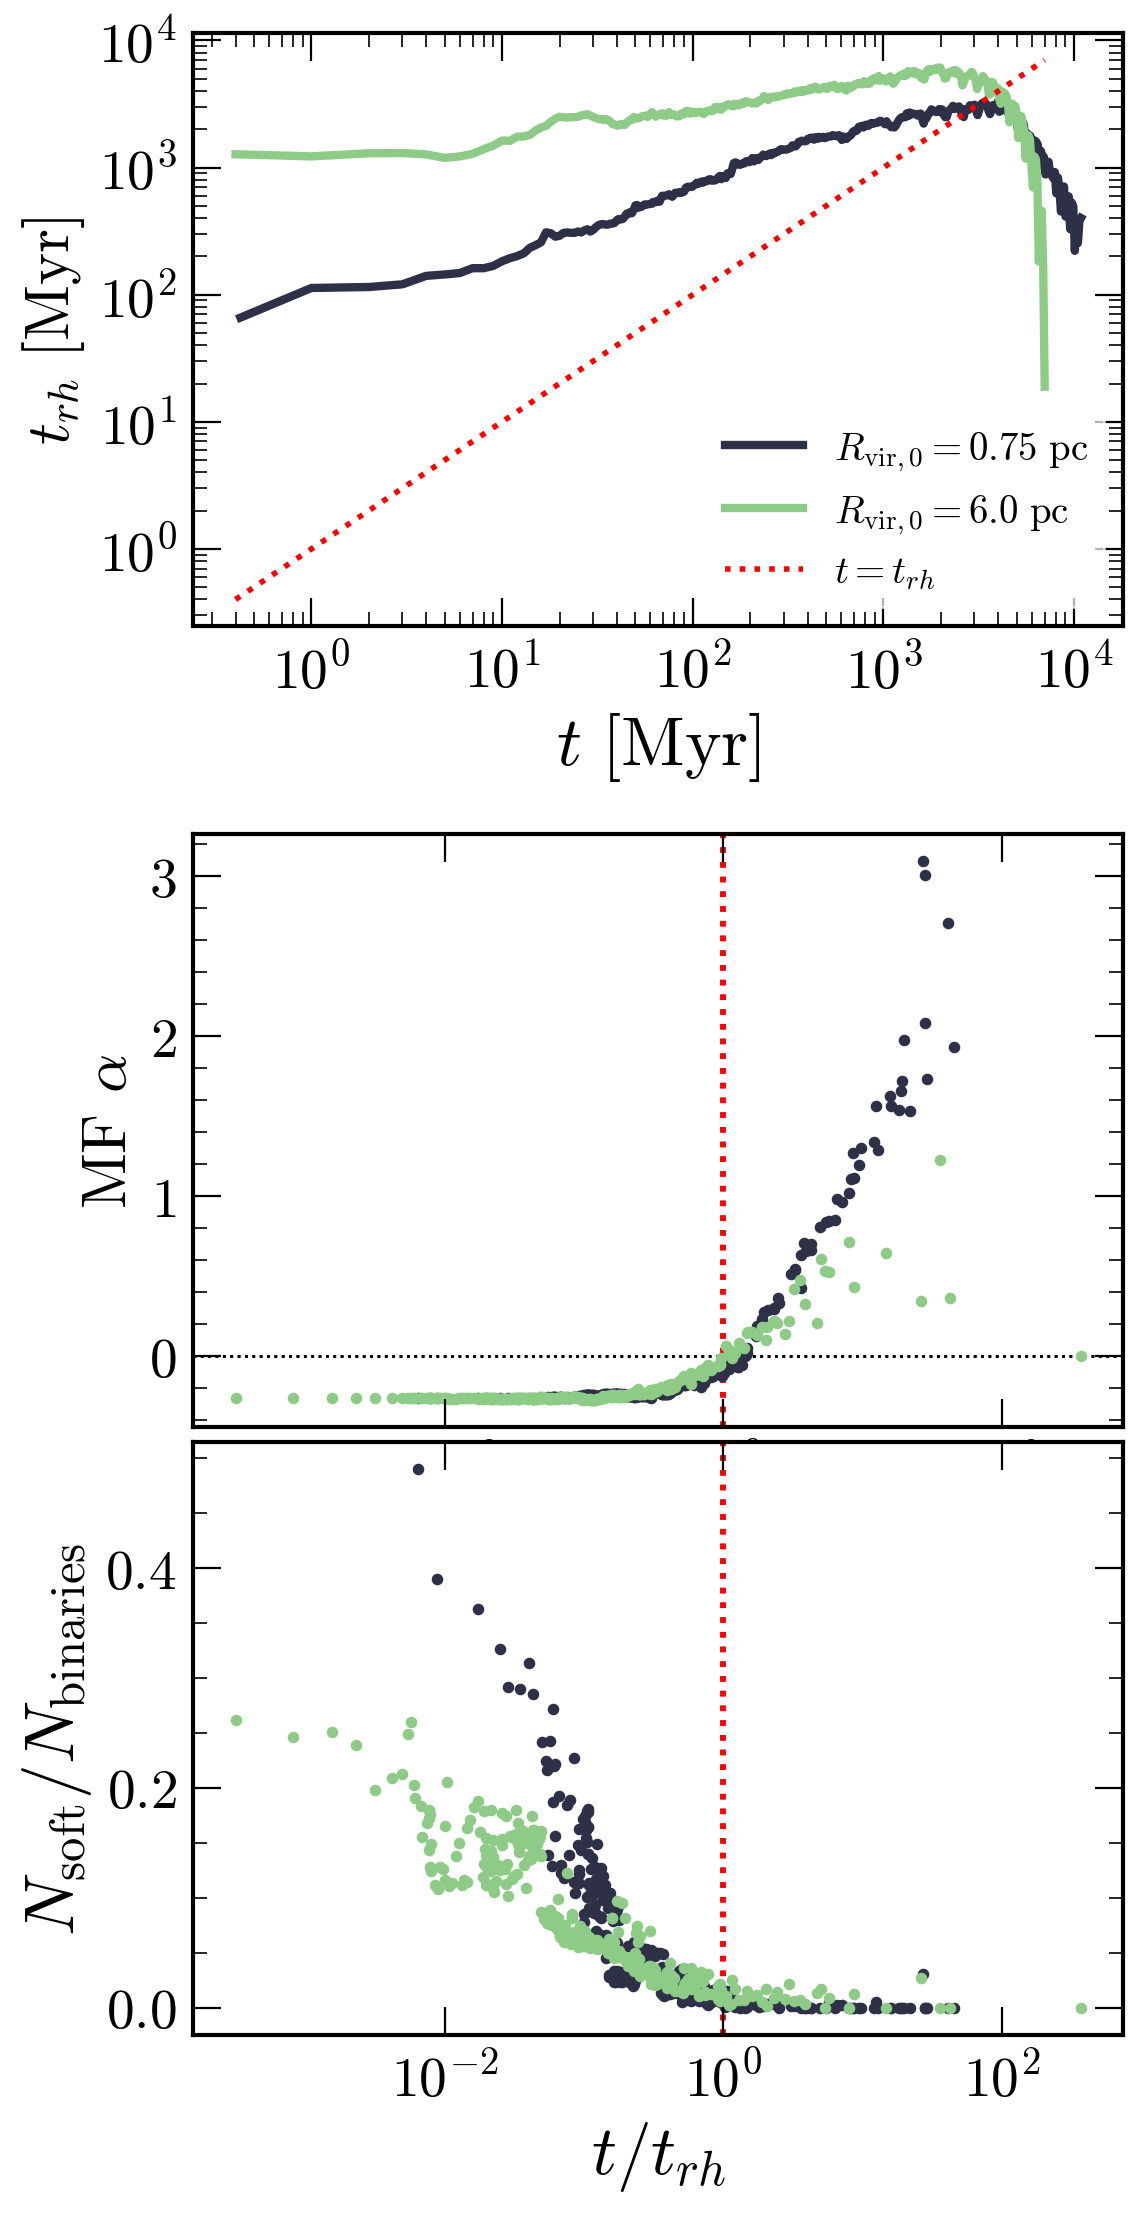

In [8]:
# make plot


axspace=0.3
fig, axs = plt.subplots(4,1, figsize=[6,13], sharey=False, sharex=False,
                        height_ratios=[1,axspace,1,1])

axs[1].remove()

plt.subplots_adjust(wspace=0.03, hspace=0.03)

colors=[lm_colors[0], lm_colors[-1]]
labels = [r'$R_{\rm vir,0}=0.75~\rm pc$',r'$R_{\rm vir,0}=6.0~\rm pc$']
for k, n in enumerate(n_vals):
    i_list_structure = i_lists_structure[k]
    i_list_plotting = i_lists_plotting[k]
#     print(i_list_plotting)
    if k==1:
        i_list_plotting = np.concatenate([np.array([0.4]), i_list_plotting[1:]])
    # path = '/Users/anyaphillips/Desktop/harvard/research/data/grid_summary/transfer_dir%i/'%n
    path = paths[n]
    soft_fracs = soft_fracs_list[k]


    t_rh_over_time = trh_list[k].copy()
    t_rh_over_time[0] = t_rh0[n]

    MF_slopes = MF_slopes_list[k]

    tidal = petar.Tidal(interrupt_mode='bse')
    tidal.loadtxt(path+"data.tidal")


    #--------- half-mass relaxation time
    ax = axs[0]
    ax.plot(i_list_plotting, t_rh_over_time, c=colors[k], ls='-', label=labels[k])
    
    ax.set_ylabel(r'$t_{rh}\ \rm[Myr]$')
    ax.set_yscale('log')
    ax.set_xlabel(r"$t\ \rm [Myr]$", fontsize=25)
    ax.set_xscale('log')

    #-------------- mass function slope
    ax = axs[-2]
    ax.scatter(i_list_plotting[MF_slopes<100]/t_rh_over_time[MF_slopes<100],
            MF_slopes[MF_slopes<100], s=10,
            c=colors[k])
    ax.set_ylabel(r"MF $\alpha$")
    ax.axhline(0, c='k', ls=":", lw=1, zorder=0)
    ax.axvline(1, c='r', linestyle=":", lw=2, zorder=0, label=r"$t=t_{rh}$")
    ax.set_xscale('log')


    #-------- soft period binary fraction
    ax = axs[-1]
    ax.scatter(i_list_plotting/t_rh_over_time,
            soft_fracs, s=10,
            c=colors[k], ls="-", label=r"$N_{\rm soft}/N_{\rm binaries}$")#, label=r"$N_{P>100~\rm yr}/N_{\rm binaries}$")#, label='sim %i'%n)

    ax.set_xlabel(r"$t/t_{rh}$",#\ \rm [Myr]$", 
                fontsize=25)
    ax.axvline(1, c='r', linestyle=":", lw=2, zorder=0, label=r"$t=t_{rh}$")
    ax.set_xscale('log')
    ax.set_ylabel(r"$N_{\rm soft}/N_{\rm binaries}$", fontsize=25)
    axs[1].set_ylim(1e-1, 9e4)


    #----------- binary fractions in period windows
    # a

x = [min(i_list_plotting), max(i_list_plotting)]
axs[0].plot(x,x,c='r', ls=":", linewidth=2, label=r"$t=t_{rh}$")
axs[0].legend(loc='lower right', framealpha=0.7, fontsize=14)
plt.savefig("plots/depleting_longperiods_with_mass_seg.pdf", dpi=300, bbox_inches="tight")

# examining binary fractions in different period ranges in the cluster??

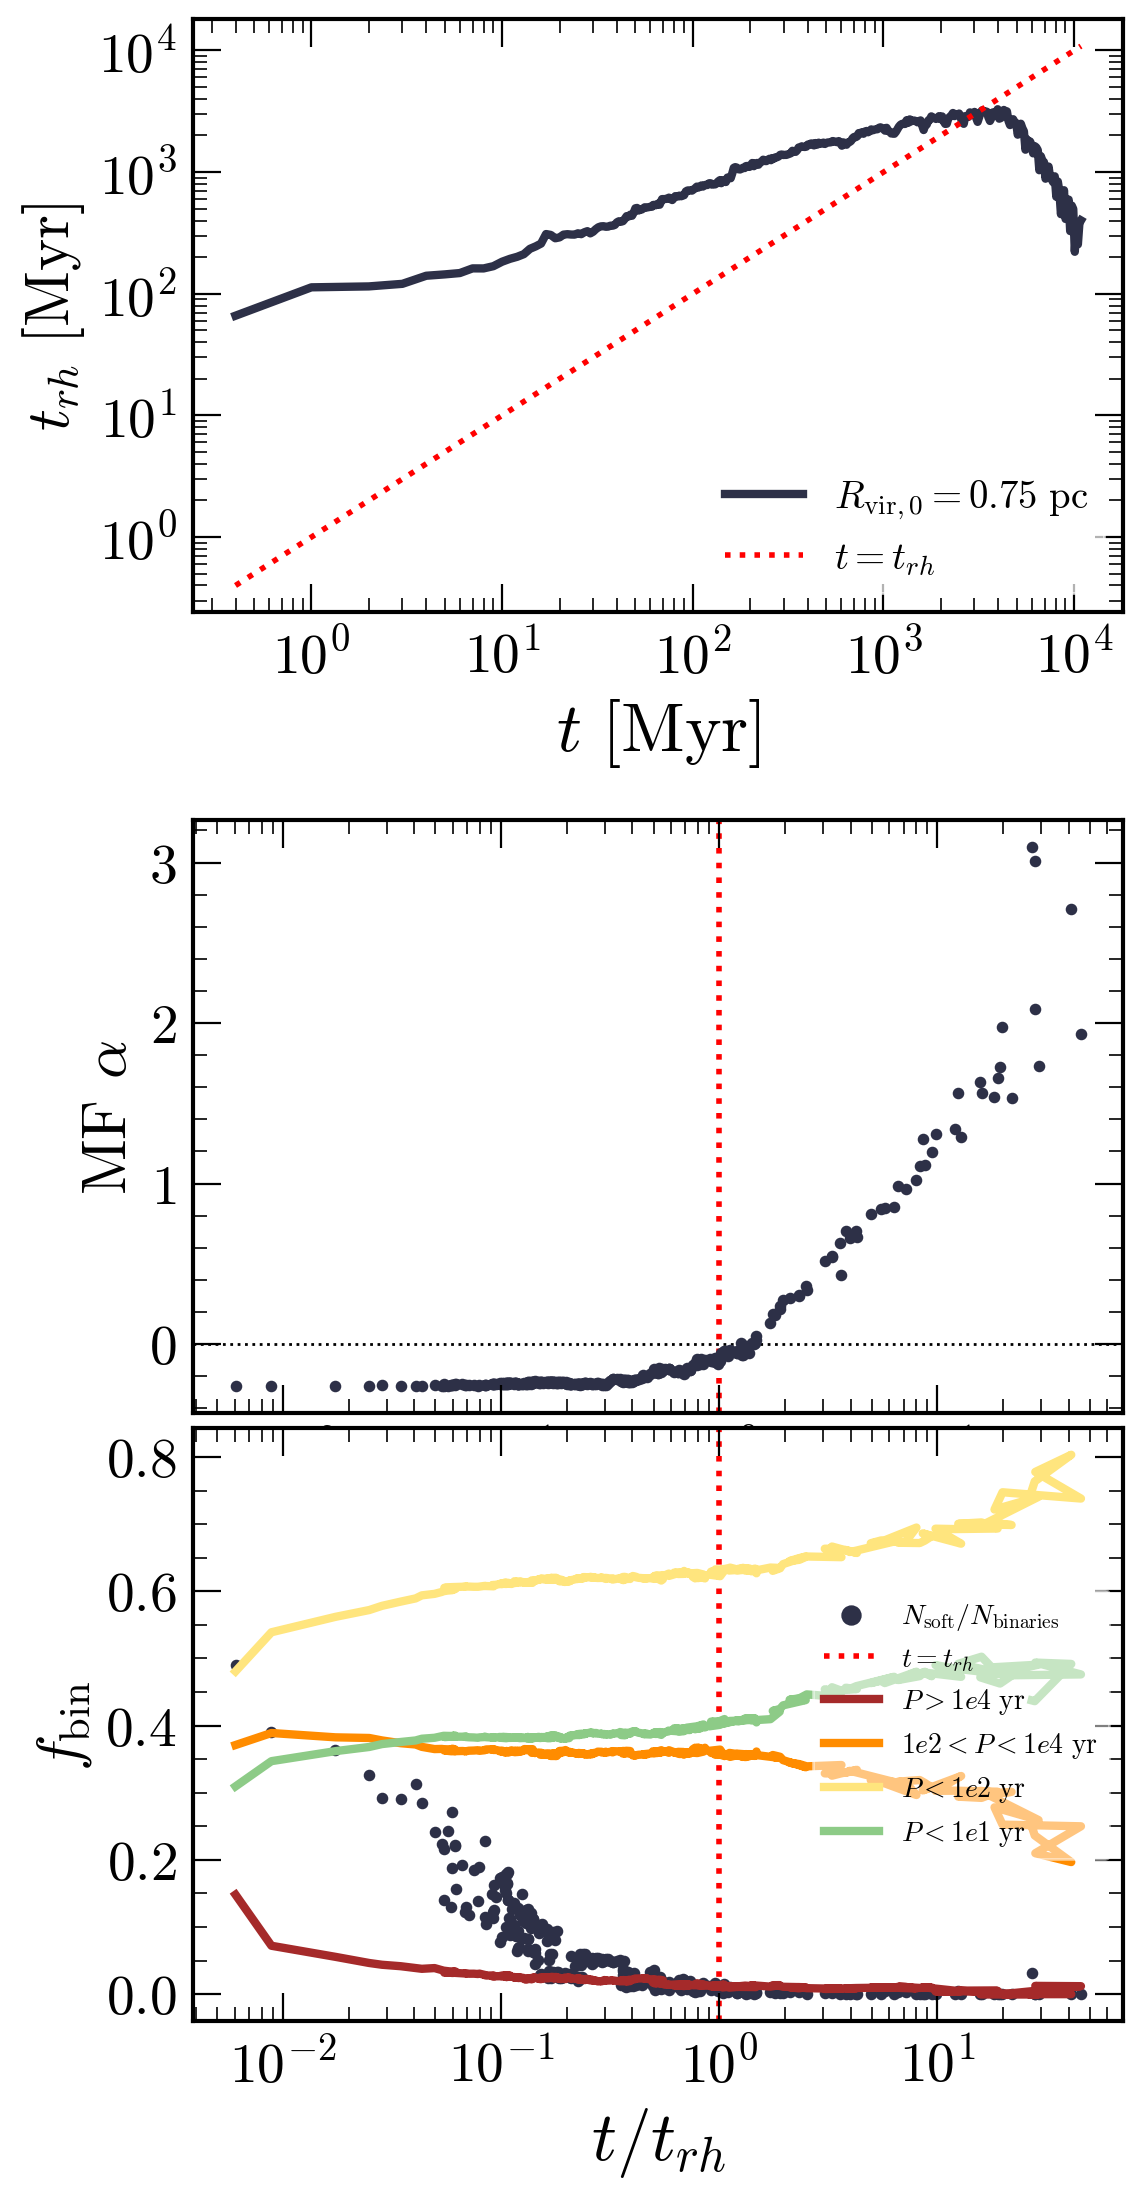

In [ ]:
axspace=0.3
# fig, axs = plt.subplots(5,1, figsize=[6,18], sharey=False, sharex=False,
#                         height_ratios=[1,axspace,1,1,1])

fig, axs = plt.subplots(4,1, figsize=[6,13], sharey=False, sharex=False,
                        height_ratios=[1,axspace,1,1])

axs[1].remove()

plt.subplots_adjust(wspace=0.03, hspace=0.03)

colors=[lm_colors[0], lm_colors[-1]]
labels = [r'$R_{\rm vir,0}=0.75~\rm pc$',r'$R_{\rm vir,0}=6.0~\rm pc$']
for k, n in enumerate(n_vals):
    i_list_structure = i_lists_structure[k]
    i_list_plotting = i_lists_plotting[k]
#     print(i_list_plotting)
    if k==1:
        i_list_plotting = np.concatenate([np.array([0.4]), i_list_plotting[1:]])
    # path = '/Users/anyaphillips/Desktop/harvard/research/data/grid_summary/transfer_dir%i/'%n
    path = paths[n]
    soft_fracs = soft_fracs_list[k]

    fracs_1e1 = fracs_1e1_list[k]
    fracs_1e2 = fracs_1e2_list [k]
    fracs_1e2_4 = fracs_1e2_4_list[k]
    fracs_1e4 = fracs_1e4_list[k]


    t_rh_over_time = trh_list[k].copy()
    t_rh_over_time[0] = t_rh0[n]

    MF_slopes = MF_slopes_list[k]

    tidal = petar.Tidal(interrupt_mode='bse')
    tidal.loadtxt(path+"data.tidal")


    #--------- half-mass relaxation time
    ax = axs[0]
    ax.plot(i_list_plotting, t_rh_over_time, c=colors[k], ls='-', label=labels[k])
    
    ax.set_ylabel(r'$t_{rh}\ \rm[Myr]$')
    ax.set_yscale('log')
    ax.set_xlabel(r"$t\ \rm [Myr]$", fontsize=25)
    ax.set_xscale('log')

    #-------------- mass function slope
    ax = axs[2]
    ax.scatter(i_list_plotting[MF_slopes<100]/t_rh_over_time[MF_slopes<100],
            MF_slopes[MF_slopes<100], s=10,
            c=colors[k])
    ax.set_ylabel(r"MF $\alpha$")
    ax.axhline(0, c='k', ls=":", lw=1, zorder=0)
    ax.axvline(1, c='r', linestyle=":", lw=2, zorder=0, label=r"$t=t_{rh}$")
    ax.set_xscale('log')


    #-------- soft period binary fraction
    ax = axs[3]
    ax.scatter(i_list_plotting/t_rh_over_time,
            soft_fracs, s=10,
            c=colors[k], ls="-", label=r"$N_{\rm soft}/N_{\rm binaries}$")#, label=r"$N_{P>100~\rm yr}/N_{\rm binaries}$")#, label='sim %i'%n)

    ax.set_xlabel(r"$t/t_{rh}$",#\ \rm [Myr]$", 
                fontsize=25)
    ax.axvline(1, c='r', linestyle=":", lw=2, zorder=0, label=r"$t=t_{rh}$")
    ax.set_xscale('log')

    # ax.set_ylim(-.01, 0.5)
    # ax.set_ylabel(r"$N_{\rm soft}/N_{\rm binaries}$", fontsize=25)


    #----------- binary fractions in period windows
    # ax = axs[3]
    ax.plot(i_list_plotting/t_rh_over_time,
               fracs_1e4, #s=5, 
               color='brown', label=r'$P>1e4~\rm yr$')
    ax.plot(i_list_plotting/t_rh_over_time,
               fracs_1e2_4, #s=5, 
               color='darkorange', label=r'$1e2<P<1e4~\rm yr$')
    
    ax.plot(i_list_plotting/t_rh_over_time,
               fracs_1e2, #s=5, 
               color=hm_colors[-1], label=r'$P<1e2~\rm yr$')

    ax.plot(i_list_plotting/t_rh_over_time, 
               fracs_1e1, # s=5,
                 color=lm_colors[-1], label=r'$P<1e1~\rm yr$')

    # ax.set_ylim(-.01, 0.5)
    ax.set_xscale('log')

    ax.legend(loc='center right', fontsize=10, framealpha=0.5, markerscale=2)

    ax.set_ylabel(r'$f_{\rm bin}$')


x = [min(i_list_plotting), max(i_list_plotting)]
axs[0].plot(x,x,c='r', ls=":", linewidth=2, label=r"$t=t_{rh}$")
axs[0].legend(loc='lower right', framealpha=0.7, fontsize=14)


In [34]:
# DO AGAIN FOR SIM 14 -- LESS MASS SEGREGATED...
n_vals=[14]

i_lists_structure14 = []
i_lists_plotting14 = []
soft_fracs_list14 = []
fracs_1e1_list14 = []
fracs_1e2_list14 = []
fracs_1e2_4_list14 = []
fracs_1e4_list14 = []

MF_slopes_list14 = []
trh_list14 = []

for n in n_vals:

    path = paths[n]
    # path = '/Users/anyaphillips/Desktop/harvard/research/data/grid_summary/transfer_dir%i/'%n # for my machine. 

    print("sim", n)
    tdis = dissolution_times[n]
    i_list = np.logspace(0, np.log10(tdis), 500).astype(int)
    i_list_real = np.unique(i_list)
    i_list_plotting = np.concatenate([np.array([t_dyn0[n]]), i_list_real]) # idk...
    i_list_structure = np.concatenate([np.zeros(1), i_list_real]) # before had i_list_real[1:] ? 

    # also want to collect MFs
    bins = np.arange(-0.65, 0.25, 0.1)
    bin_centers = (bins[:-1]+bins[1:])/2

    # collect soft binary fractions
    soft_fracs = []
    MF_slopes = []
    t_rh_over_time = []

    fracs_1e1 = []
    # fracs_1e1_2 = []
    fracs_1e2 = []
    fracs_1e2_4 = []
    fracs_1e4 = []

    for i in tqdm(i_list_structure.astype(int)):
        ahs, br, a, mtot, rh, in_rtid_late = paf.compute_ahs(path, i=i, shell_width=1*u.pc)
        Phs = paf.calc_P(ahs, mtot) # should be only in-cluster binaries
        periods = paf.calc_P(a, mtot)
        n_binaries = len(periods)


        particles = paf.load_particle(path, i)
        rrel, clip = paf.clip_outside_rtid(path, particles, i, in_core_frame=False)
        masses = particles.mass[clip]
        logM = np.log10(masses)


        N = len(logM)
        if N==0:
            MF_slopes.append(999.)
        if N>0:
            # do relaxation time
            hmr = paf.calculate_half_mass_radius(particles.mass[clip]*u.Msun, rrel[clip].to(u.pc)) * u.pc

            shell_width = 1.*u.pc
            inner = hmr-shell_width
            outer = hmr+shell_width
            in_shell = (rrel>inner) & (rrel<outer)
            shell_volume = (4*np.pi/3) * (outer**3 - inner**3)
            shell_mass = np.sum(particles.mass[in_shell]) * u.Msun
            shell_density = shell_mass / shell_volume        
            t_cross = (const.G * shell_density)**(-1/2)
            # print(t_cross.decompose().unit)
            t_rh = ((0.1*N)/(np.log(N))) * t_cross
            t_rh_over_time.append(t_rh.to(u.Myr).value)

            # do MF slope:
            y, edges = np.histogram(logM, bins)
            bin_widths = np.diff(bins)
            y = N**(-1) * y/bin_widths
            ind_0, ind_1 = 0, 3 # the first and fourth bin centers will define the slope
            dy = np.log10(y[ind_1])-np.log10(y[ind_0])
            dm = bin_centers[ind_1]-bin_centers[ind_0] 
            MF_slope = dy/dm
            MF_slopes.append(MF_slope)

        if n_binaries>0:
            n_wide = len(periods[periods>Phs])
            f_wide = n_wide / n_binaries
            soft_fracs.append(f_wide)

            n = len(periods[periods.to(u.yr)<=1e1*u.yr])
            f = n/n_binaries
            fracs_1e1.append(f)

            n = len(periods[periods<=1e2*u.yr])
            f = n/n_binaries
            fracs_1e2.append(f)

            n = len(periods[(periods<=1e4*u.yr) & (periods>1e2*u.yr)])
            f = n/n_binaries
            fracs_1e2_4.append(f)

            n = len(periods[periods>1e4*u.yr])
            f = n/n_binaries
            fracs_1e4.append(f)


    soft_fracs = np.array(soft_fracs)
    fracs_1e2 = np.array(fracs_1e2)
    fracs_1e1 = np.array(fracs_1e1)
    fracs_1e2_4 = np.array(fracs_1e2_4)
    fracs_1e4 = np.array(fracs_1e4)

    MF_slopes = np.array(MF_slopes)
    t_rh_over_time = np.array(t_rh_over_time)

    i_lists_structure14.append(i_list_structure)
    i_lists_plotting14.append(i_list_plotting)
    soft_fracs_list14.append(soft_fracs)
    fracs_1e1_list14.append(fracs_1e1)
    fracs_1e2_list14.append(fracs_1e2)
    fracs_1e2_4_list14.append(fracs_1e2_4)
    fracs_1e4_list14.append(fracs_1e4)
    MF_slopes_list14.append(MF_slopes)
    trh_list14.append(t_rh_over_time)

sim 14


  2%|▏         | 8/329 [00:20<14:36,  2.73s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  3%|▎         | 9/329 [00:23<14:18,  2.68s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  3%|▎         | 10/329 [00:25<14:08,  2.66s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  3%|▎         | 11/329 [00:28<13:49,  2.61s/it]/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide 

In [36]:
soft_fracs_list14[0]

array([0.26181545, 0.24633872, 0.25150376, 0.23965388, 0.19872036,
       0.20911831, 0.21334338, 0.24943396, 0.26029467, 0.20333207,
       0.19105383, 0.18396047, 0.15557246, 0.16856925, 0.17328244,
       0.14340344, 0.18000766, 0.14938556, 0.12869766, 0.17653846,
       0.12427857, 0.11209553, 0.10824345, 0.12870906, 0.12683115,
       0.16557314, 0.11660232, 0.20525705, 0.11068111, 0.11416409,
       0.13870593, 0.15056267, 0.11232025, 0.11677696, 0.11492014,
       0.16374269, 0.17148437, 0.18288394, 0.18842846, 0.1605325 ,
       0.11956096, 0.13098039, 0.17896389, 0.14454046, 0.12908304,
       0.13322822, 0.13907546, 0.15500198, 0.11273734, 0.11159478,
       0.12752475, 0.11150794, 0.12504962, 0.14331084, 0.13418023,
       0.18026263, 0.10951812, 0.13790355, 0.11532322, 0.106     ,
       0.12645058, 0.1532613 , 0.12730184, 0.13015619, 0.12705411,
       0.1255012 , 0.15341365, 0.14859438, 0.17751004, 0.12660772,
       0.11303298, 0.10229561, 0.13134569, 0.17485898, 0.15564

329 329


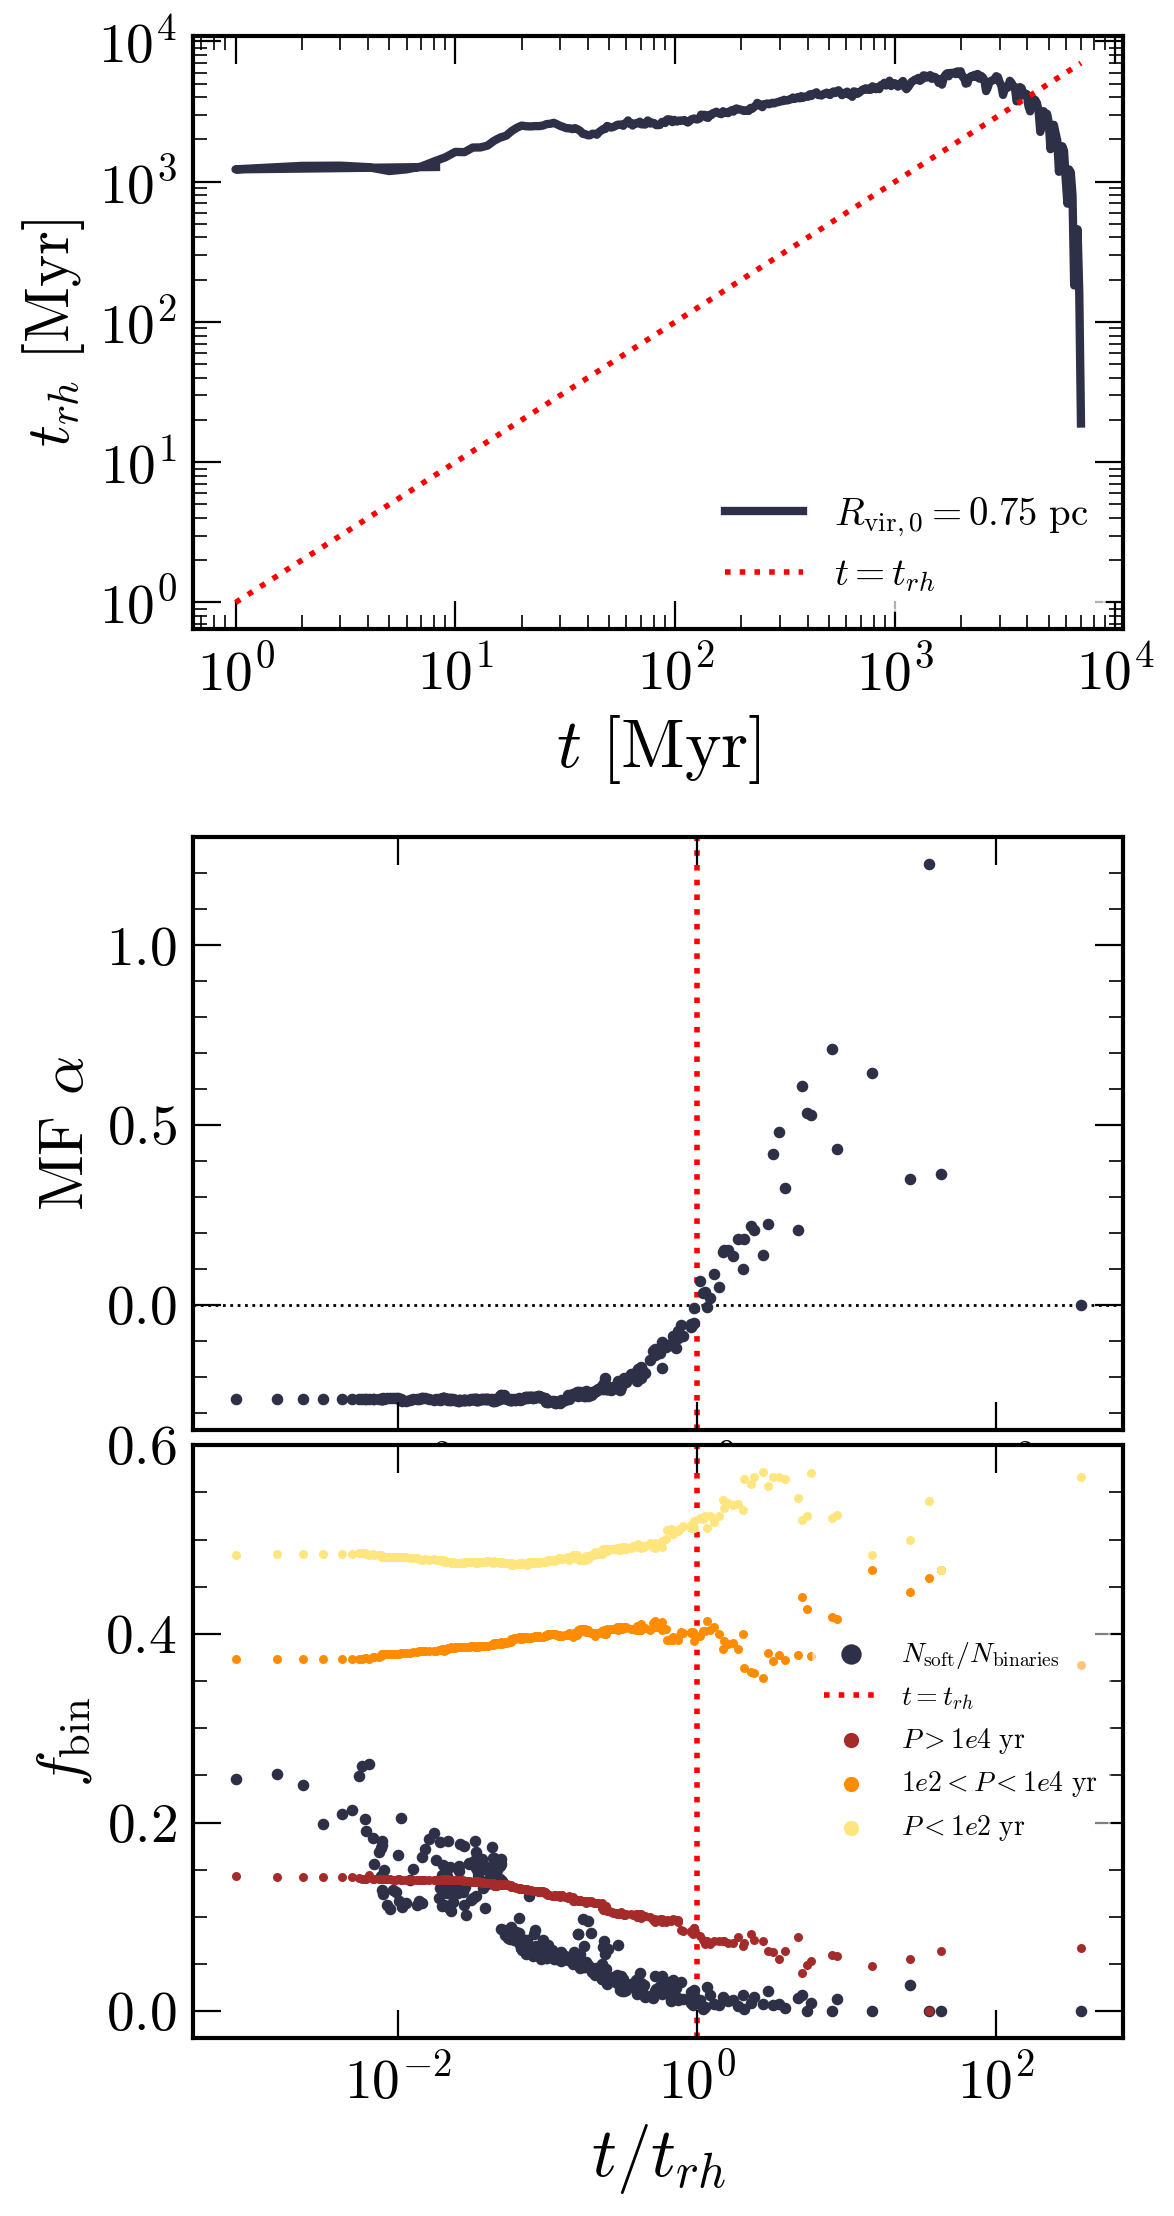

In [46]:
axspace=0.3
# fig, axs = plt.subplots(5,1, figsize=[6,18], sharey=False, sharex=False,
#                         height_ratios=[1,axspace,1,1,1])

fig, axs = plt.subplots(4,1, figsize=[6,13], sharey=False, sharex=False,
                        height_ratios=[1,axspace,1,1])

axs[1].remove()

plt.subplots_adjust(wspace=0.03, hspace=0.03)

colors=[lm_colors[0], lm_colors[-1]]
labels = [r'$R_{\rm vir,0}=0.75~\rm pc$',r'$R_{\rm vir,0}=6.0~\rm pc$']
for k, n in enumerate(n_vals):
    i_list_structure = i_lists_structure14[k]
    i_list_plotting = i_lists_plotting14[k]

#     print(i_list_plotting)
    # if k==1:
    # i_list_plotting = np.concatenate([np.array([0.4]), i_list_plotting[1:]])
    # path = '/Users/anyaphillips/Desktop/harvard/research/data/grid_summary/transfer_dir%i/'%n
    path = paths[n]
    soft_fracs = soft_fracs_list14[k]

    fracs_1e1 = fracs_1e1_list14[k]
    fracs_1e2 = fracs_1e2_list14[k]
    fracs_1e2_4 = fracs_1e2_4_list14[k]
    fracs_1e4 = fracs_1e4_list14[k]

    print(len(i_list_plotting), len(soft_fracs))


    t_rh_over_time = trh_list14[k].copy()
    t_rh_over_time[0] = t_rh0[n]

    MF_slopes = MF_slopes_list14[k]

    tidal = petar.Tidal(interrupt_mode='bse')
    tidal.loadtxt(path+"data.tidal")


    #--------- half-mass relaxation time
    ax = axs[0]
    ax.plot(i_list_plotting, t_rh_over_time, c=colors[k], ls='-', label=labels[k])
    
    ax.set_ylabel(r'$t_{rh}\ \rm[Myr]$')
    ax.set_yscale('log')
    ax.set_xlabel(r"$t\ \rm [Myr]$", fontsize=25)
    ax.set_xscale('log')

    #-------------- mass function slope
    ax = axs[2]
    ax.scatter(i_list_plotting[MF_slopes<100]/t_rh_over_time[MF_slopes<100],
            MF_slopes[MF_slopes<100], s=10,
            c=colors[k])
    ax.set_ylabel(r"MF $\alpha$")
    ax.axhline(0, c='k', ls=":", lw=1, zorder=0)
    ax.axvline(1, c='r', linestyle=":", lw=2, zorder=0, label=r"$t=t_{rh}$")
    ax.set_xscale('log')


    #-------- soft period binary fraction
    ax = axs[3]
    ax.scatter(i_list_plotting/t_rh_over_time,
            soft_fracs, s=10,
            c=colors[k], ls="-", label=r"$N_{\rm soft}/N_{\rm binaries}$")#, label=r"$N_{P>100~\rm yr}/N_{\rm binaries}$")#, label='sim %i'%n)

    ax.set_xlabel(r"$t/t_{rh}$",#\ \rm [Myr]$", 
                fontsize=25)
    ax.axvline(1, c='r', linestyle=":", lw=2, zorder=0, label=r"$t=t_{rh}$")
    ax.set_xscale('log')

    # ax.set_ylim(-.01, 0.5)
    # ax.set_ylabel(r"$N_{\rm soft}/N_{\rm binaries}$", fontsize=25)


    #----------- binary fractions in period windows
    # ax = axs[3]
    ax.scatter(i_list_plotting/t_rh_over_time,
               fracs_1e4, s=5, 
               color='brown', label=r'$P>1e4~\rm yr$')
    ax.scatter(i_list_plotting/t_rh_over_time,
               fracs_1e2_4, s=5, 
               color='darkorange', label=r'$1e2<P<1e4~\rm yr$')
    
    ax.scatter(i_list_plotting/t_rh_over_time,
               fracs_1e2, s=5, 
               color=hm_colors[-1], label=r'$P<1e2~\rm yr$')

    # ax.plot(i_list_plotting/t_rh_over_time, 
    #            fracs_1e1, # s=5,
    #              color=lm_colors[-1], label=r'$P<1e1~\rm yr$')

    # ax.set_ylim(-.01, 0.5)
    ax.set_xscale('log')

    ax.legend(loc='center right', fontsize=10, framealpha=0.5, markerscale=2)

    ax.set_ylabel(r'$f_{\rm bin}$')


x = [min(i_list_plotting), max(i_list_plotting)]
axs[0].plot(x,x,c='r', ls=":", linewidth=2, label=r"$t=t_{rh}$")
axs[0].legend(loc='lower right', framealpha=0.7, fontsize=14)
